In [1]:
from tensorflow import keras
from keras.applications import vgg16
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

Using TensorFlow backend.


In [2]:
# parameters setup
imgs_path = "./content/data/style"
imgs_model_width, imgs_model_height = 224, 224
nb_closest_images = 5 # number of most similar images to retrieve

In [3]:
# load the model
vgg_model = vgg16.VGG16(weights='imagenet')
# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input,
outputs=vgg_model.get_layer("fc2").output)
# print the layers of the CNN
feat_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
files = []
for x in os.listdir(imgs_path):
    if 'png' in x:
        # print(x)
        files.append(f"{imgs_path}/{x}")
        # break

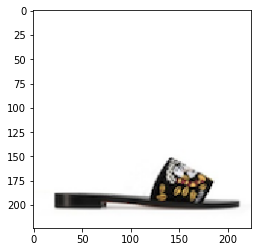

image loaded successfully!


In [5]:
# load an image in PIL format
original = load_img(files[1],target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image loaded successfully!")

In [6]:
# in PIL - image is in (width, height, channel)
# in Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)
# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)
# prepare the image for the VGG model
processed_image = preprocess_input(image_batch.copy())

image batch size (1, 224, 224, 3)


In [7]:
# load all the images and prepare them for feeding into the CNN
importedImages = []
for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    importedImages.append(image_batch)
images = np.vstack(importedImages)
processed_imgs = preprocess_input(images.copy())

In [8]:
imgs_features = feat_extractor.predict(processed_imgs)
print("features successfully extracted!")
imgs_features.shape

features successfully extracted!


(2184, 4096)

In [9]:
# compute cosine similarities between images
cosSimilarities = cosine_similarity(imgs_features)
# store the results into a pandas dataframe
cos_similarities_df = pd.DataFrame(cosSimilarities,
columns=files, index=files)
cos_similarities_df.head()

,./content/data/style/2_0_015.png,./content/data/style/4_0_016.png,./content/data/style/3_7_018.png,./content/data/style/6_7_010.png,./content/data/style/3_5_018.png,./content/data/style/5_4_011.png,./content/data/style/1_2_004.png,./content/data/style/3_0_034.png,./content/data/style/6_2_010.png,./content/data/style/6_2_028.png,...,./content/data/style/2_5_003.png,./content/data/style/2_2_055.png,./content/data/style/3_2_002.png,./content/data/style/3_0_029.png,./content/data/style/4_5_017.png,./content/data/style/2_2_054.png,./content/data/style/1_8_025.png,./content/data/style/0_0_067.png,./content/data/style/6_1_049.png,./content/data/style/1_2_041.png
./content/data/style/2_0_015.png,1.000000,0.421119,0.472786,0.377105,0.412209,0.266400,0.393732,0.367840,0.360758,0.334755,...,0.280853,0.430655,0.404478,0.601970,0.302336,0.469947,0.540249,0.427571,0.230765,0.322533
./content/data/style/4_0_016.png,0.421119,1.000000,0.305686,0.274623,0.267477,0.293341,0.350783,0.333737,0.279782,0.255966,...,0.145052,0.282716,0.367465,0.415130,0.181927,0.337380,0.213185,0.289293,0.217343,0.213767
./content/data/style/3_7_018.png,0.472786,0.305686,1.000000,0.379906,0.341073,0.375105,0.324961,0.313762,0.331904,0.333682,...,0.245356,0.345256,0.354227,0.543603,0.206340,0.331968,0.366298,0.363340,0.198617,0.242955
./content/data/style/6_7_010.png,0.377105,0.274623,0.379906,1.000000,0.248601,0.369752,0.280926,0.282345,0.312696,0.375110,...,0.210353,0.381127,0.391302,0.357877,0.177704,0.377398,0.245263,0.251533,0.298652,0.284669
./content/data/style/3_5_018.png,0.412209,0.267477,0.341073,0.248601,1.000000,0.320309,0.295500,0.320563,0.343428,0.369726,...,0.461571,0.316005,0.309438,0.433132,0.548128,0.475728,0.333946,0.330855,0.195237,0.279590


In [10]:
cos_similarities_df.to_csv("model.csv")

In [11]:
def retrieve_most_similar_products(given_img, df):
    print("-"*50)
    print("original product:")
    original = load_img(given_img, target_size=(imgs_model_width,      imgs_model_height))
    plt.imshow(original)
    plt.show()
    print("-"*50)
    print("most similar products:")
    closest_imgs = df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]
    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])

In [12]:
def load_data():
    df = pd.read_csv('model.csv')
    df.set_index("Unnamed: 0", inplace=True)
    return df

In [14]:
def names():
    list_data = os.listdir('content/data/style')
   
    return list_data

2_0_025.png
--------------------------------------------------
original product:


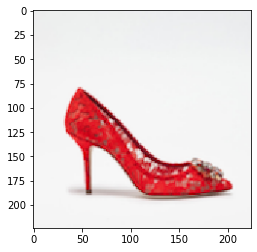

--------------------------------------------------
most similar products:


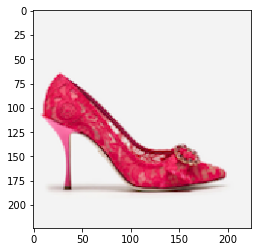

similarity score :  0.8979486


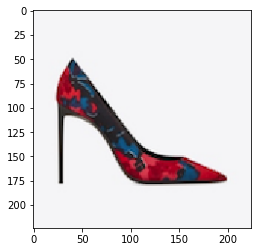

similarity score :  0.86667126


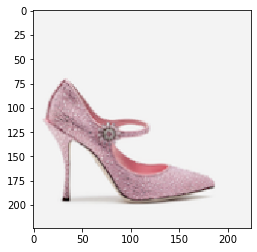

similarity score :  0.8244213


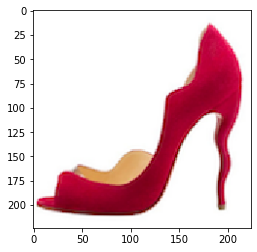

similarity score :  0.7772858


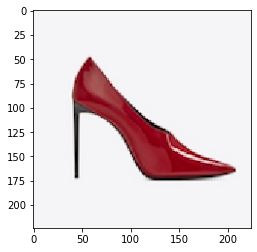

similarity score :  0.77702755


In [15]:
name = names()
n = '2_0_025.png'
print(n)
if n is not None:
    path = "./content/data/style/"+n
    df = load_data()
    #print(df)
           
    retrieve_most_similar_products(path,df)
else:
    print("Write the path name")